<a href="https://colab.research.google.com/github/iwatake2222/3D_SpaceMouse/blob/master/object_detection/beer_detection/beer_detection_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection model inference
- dataset: beer
- pretrained model: faster_rcnn_resnet101_coco

## Preparation

In [0]:
from google.colab import drive 
drive.mount('/content/drive')

!ls
MODEL_DIR = "/content/drive/My Drive/training/beer_detection/faster_rcnn_resnet101_coco_11_06_2017_20191230/exported_graphs"
LABEL_FILE = "/content/drive/My Drive/datasets/beer/tf_label_map.pbtxt"
TEST_IMAGE = "/content/drive/My Drive/datasets/beer/images/20190922_201632.jpg"

In [2]:
%tensorflow_version 2.x
# restart runtime
# !pip install tensorflow==2
import tensorflow as tf
print(tf.__version__)
!pip install pycocotools
!pip list

!git clone --depth 1 https://github.com/tensorflow/models
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.
!pip install .
%cd /content

TensorFlow 2.x selected.
2.1.0-rc1
Package                  Version    
------------------------ -----------
absl-py                  0.9.0      
alabaster                0.7.12     
albumentations           0.1.12     
altair                   4.0.0      
asgiref                  3.2.3      
astor                    0.8.1      
astropy                  3.0.5      
atari-py                 0.2.6      
atomicwrites             1.3.0      
attrs                    19.3.0     
audioread                2.1.8      
autograd                 1.3        
Babel                    2.7.0      
backcall                 0.1.0      
backports.tempfile       1.0        
backports.weakref        1.0.post1  
beautifulsoup4           4.6.3      
bleach                   3.1.0      
blis                     0.2.4      
bokeh                    1.0.4      
boto                     2.49.0     
boto3                    1.10.40    
botocore                 1.13.40    
Bottleneck               1.3.1      
bra

## Run inference

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]
{'raw_detection_scores': TensorShape([None, 300, 11]), 'detection_multiclass_scores': TensorShape([None, 100, 11]), 'detection_classes': TensorShape([None, 100]), 'num_detections': TensorShape([None]), 'detection_boxes': TensorShape([None, 100, 4]), 'raw_detection_boxes': TensorShape([None, 300, 4]), 'detection_features': TensorShape([None, None, None, None, None]), 'detection_scores': TensorShape([None, 100])}


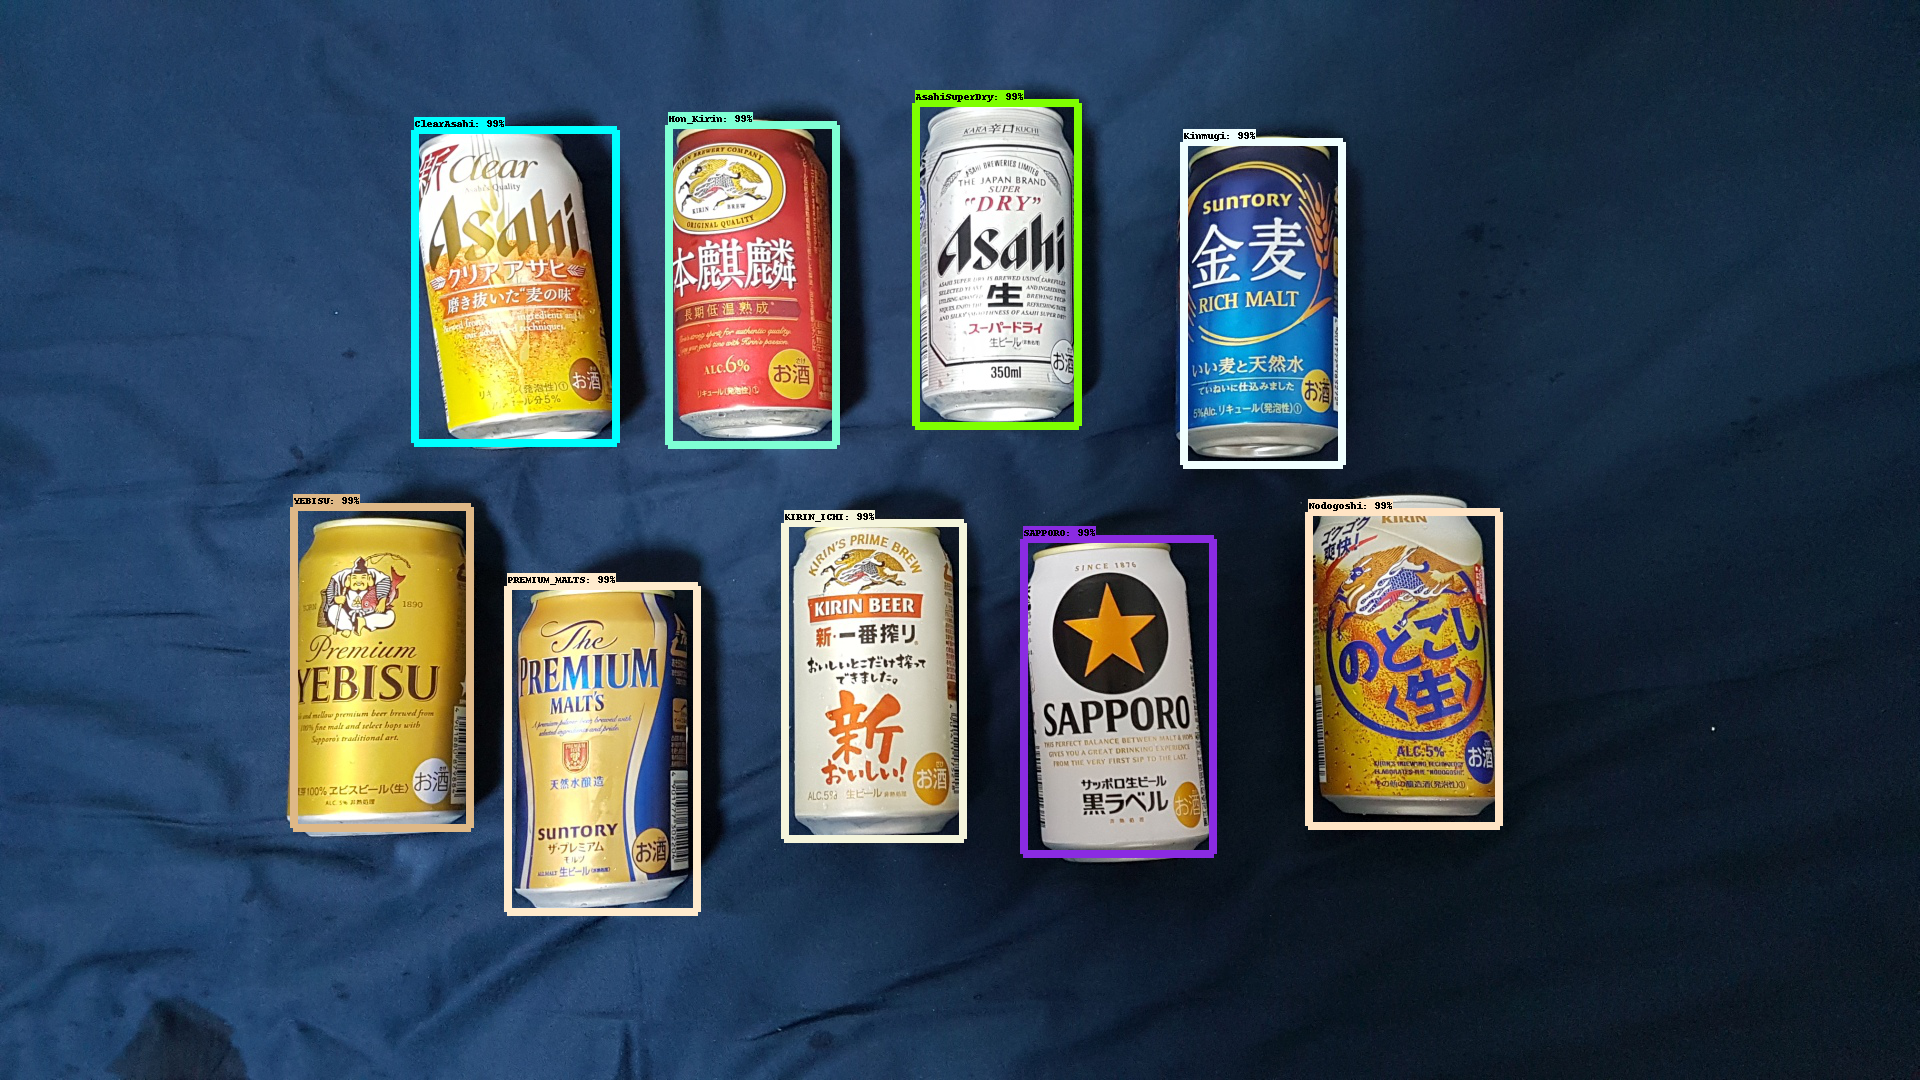

In [5]:
from pathlib import Path
import pathlib

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)
  model_dir = pathlib.Path(model_dir)/"saved_model"

  # model = tf.saved_model.load(str(model_dir))
  model = tf.compat.v2.saved_model.load(str(model_dir), None)
  model = model.signatures['serving_default']
  return model

def load_my_model(model_dir):
  model_dir = pathlib.Path(model_dir)/"saved_model"

  # model = tf.saved_model.load(str(model_dir))
  model = tf.compat.v2.saved_model.load(str(model_dir), None)
  model = model.signatures['serving_default']
  return model

category_index = label_map_util.create_category_index_from_labelmap(LABEL_FILE, use_display_name=True)

# detection_model = load_model("ssd_mobilenet_v1_coco_2017_11_17")
detection_model = load_my_model(MODEL_DIR)

print(detection_model.inputs)
print(detection_model.output_shapes)


def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))


show_inference(detection_model, TEST_IMAGE)
